# Демонстрация построения каскада моделей
# !!!Выборка с данными для запуска скрипта не предоставляется

## 1. Загрузка библиотек и выборок

In [1]:
import pandas as pd
import numpy as np
from vtb_scorekit.data import DataSamples
from vtb_scorekit.woe import WOE
from vtb_scorekit.model import LogisticRegressionModel
from vtb_scorekit.cascade import Cascade
import random

### для запуска скрипта необходимо использовать свою выборку 
df = ...
module_features = ...
###

special_bins = {'vip': -999999999999}
df.loc[df['vip'] == 1, module_features['PRAVO']] = special_bins['vip']  # спец бин для ВИП сегмента в модуле PRAVO
df['year'] = df['report_date'].astype('str').str[:4]
df['random_score'] = [random.random() for _ in range(len(df))]          # случайный скор для примера 
df   


,calc_hub_id,inn,slx,ead,off_bal_ead,on_bal_ead,tot_debt,scale_rwa,train_flg,def_flg,...,max_segment_calc_date,inn_corr,slx_corr,id_corr_flg,calculation_source,processed_dt,report_date,report_dt,year,random_score
0,None,4207055973,L6UJ9A001MAH,0.473,None,None,None,None,0,0,...,None,4207055973,L6UJ9A001MAH,no_corr,RETRO,None,2018-06-30,2018-06-30,2018,0.265
1,None,1435125448,L6UJ9A001R83,0.100,None,None,None,None,1,0,...,None,1435125448,L6UJ9A001R83,no_corr,RETRO,None,2018-06-30,2018-06-30,2018,0.370
2,None,3812035570,L6UJ9A000130,4.357,None,None,None,None,1,0,...,None,3812035570,L6UJ9A000130,no_corr,RETRO,None,2018-06-30,2018-06-30,2018,0.569
3,None,3810322900,L6UJ9A009ARZ,0.161,None,None,None,None,0,0,...,None,3810322900,L6UJ9A009ARZ,no_corr,RETRO,None,2018-06-30,2018-06-30,2018,0.224
4,None,7603031989,L6UJ9A00239V,0.095,None,None,None,None,1,0,...,None,7603031989,L6UJ9A00239V,no_corr,RETRO,None,2018-06-30,2018-06-30,2018,0.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167541,None,3602007714,L6UJ9A0043OU,0.410,None,None,None,None,1,0,...,None,3602007714,L6UJ9A0043OU,no_corr,RETRO,None,2020-05-31,2020-05-31,2020,0.238
167542,None,1414008729,L6UJ9A008Q8U,0.526,None,None,None,None,1,0,...,None,1414008729,L6UJ9A008Q8U,no_corr,RETRO,None,2020-05-31,2020-05-31,2020,0.884
167543,None,5700000164,L6UJ9A000319,0.050,None,None,None,None,1,0,...,None,5700000164,L6UJ9A000319,no_corr,RETRO,None,2020-05-31,2020-05-31,2020,0.439
167544,None,6671228974,L6UJ9A003TPP,0.295,None,None,None,None,0,0,...,None,6671228974,L6UJ9A003TPP,no_corr,RETRO,None,2020-05-31,2020-05-31,2020,0.395


## 2. Создание объектов DataSamples для каждого модуля
ds - словарь вида {название модуля: DataSamples()}

In [2]:
ds = {}
for module in module_features:
    print(module)
    ds[module] = DataSamples(samples={'train': df},                                        # выборка для разработки. Задается в виде словаря {название_сэмпла: датафрейм}, может содержать любое кол-во сэмплов     
                             target='def_flg',                                             # целевая переменная
                             features=module_features[module],                             # список переменных. При None берутся все поля числового типа и нечисловые (кроме target, time_column, id_column, weights) с кол-вом уникльных значений меньше min_nunique
                             id_column='inn',                                              # уникальный в рамках среза айди наблюдения
                             time_column='year',                                           # дата среза
                             special_bins=special_bins,                                    # словарь вида {название бина: значение}, каждое из значений которого помещается в отдельный бин
                             feature_descriptions=pd.read_excel('data/PVR_description.xlsx', index_col=0), # датафрейм с описанием переменных. Должен содержать индекс с названием переменных и любое кол-во полей с описанием, которые будут подтягиваться в отчеты
                             result_folder=f'PVR/{module}',                                # папка, в которую будут сохраняться все результаты работы с этим ДатаСэмплом
                             n_jobs=4,                                                     # кол-во используемых рабочих процессов, при -1 берется число, равное CPU_LIMIT
                             random_state=0,                                               # сид для генератора случайных чисел, используется во всех остальных методах, где необходимо
                             samples_split={},                                             # словарь с параметрами для вызова метода self.samples_split
                             bootstrap_split={'df': df}                                    # словарь с параметрами для вызова метода self.bootstrap_split
                             )

FO
[INFO] [2023-06-01 14:36:22] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-06-01 14:36:22] Selected 0 categorical features: []
[INFO] [2023-06-01 14:36:24] Actual parts of samples after samples split:
      train  Test
part    0.7   0.3
[INFO] [2023-06-01 14:38:37] 100 bootstrap samples with 167546 observation each and 0.0245 mean target rate were created
[INFO] [2023-06-01 14:38:37] DataSamples stats:
                   train         Test Bootstrap base
amount            117282        50264         167546
target              2873         1231           4104
target_rate        0.024        0.024          0.024
period       2013 - 2021  2013 - 2021    2013 - 2021
PRAVO
[INFO] [2023-06-01 14:38:37] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-06-01 14:

## 3. Биннинг и обучение модели FO на заданном списке факторов

In [3]:
%%time
binning_FO = WOE(ds['FO'])
binning_FO.auto_fit(plot_flag=-1, params_space={'method': ['opt',  'tree']})
logreg_FO = LogisticRegressionModel(ds=binning_FO.transform(ds['FO']), transformer=binning_FO, name='FO')
logreg_FO.fit()

[INFO] [2023-06-01 14:42:57] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-06-01 14:42:57] Performing autobinning with parameters space of size 2...
[INFO] [2023-06-01 14:42:57] Using parameters set 1/2: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2, 'G_gini_increase_restrict': True, 'G_with_test': False, 'WOEO_on': False, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold': 0.85, 'WOEO_miss_is_incorrect': True, 'WOEO_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'verbose': False}
[INFO] [2023-06-01 14:42:57] Processing 

100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


[INFO] [2023-06-01 14:43:04] Using parameters set 2/2: {'method': 'tree', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2, 'G_gini_increase_restrict': True, 'G_with_test': False, 'WOEO_on': False, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold': 0.85, 'WOEO_miss_is_incorrect': True, 'WOEO_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'verbose': False}
[INFO] [2023-06-01 14:43:04] Processing 9 features on 4 CPUs...


100%|██████████| 9/9 [00:29<00:00,  3.22s/it]


[INFO] [2023-06-01 14:43:34] Scorecard saved to the file PVR/FO/auto_fit_scorecard.xlsx
[INFO] [2023-06-01 14:43:34] All done! 9/9 features successfully binned.
[INFO] [2023-06-01 14:43:35] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
[INFO] [2023-06-01 14:43:36] intercept = -3.636
[INFO] [2023-06-01 14:43:36] coefs = {'qn66_cur_acc_turnover_p_WOE': -0.199, 'f197_v3_WOE': -0.379, 'f143_WOE': -0.398, 'f114_WOE': -0.555, 'f64_WOE': -0.148, 'f40_WOE': -0.325, 'f194_WOE': -0.535, 'qn56_q106_cur_ratio1_WOE': -0.146, 'f93_WOE': -0.306}
CPU times: user 3.9 s, sys: 5.72 s, total: 9.62 s
Wall time: 38.7 s


## 4. Создание каскада моделей
Каскад состоит из трех модулей (FO, PRAVO и KI) и одного готового скора

In [4]:
cascade = Cascade(models=[                       # список моделей в каскаде. Элементами списка могут быть объекты класса Cascade, LogisticRegressionModel и названия полей отдельных скоров
                          logreg_FO,                                              # уже обученная вручную модель FO
                          LogisticRegressionModel(ds=ds['PRAVO'], name='PRAVO'),  # инициализированная модель PRAVO
                          LogisticRegressionModel(ds=ds['KI'], name='KI'),        # инициализированная модель KI
                         'random_score'                                           # название поля с готовым скором
                         ], 
                  integral=None,                # функция, вычисляющая интегральный скор каскада по списку скоров входящих в него моделей. При None интегральный скор вычисляется логрегом
                  ds=ds['FO'],                  # ДатаСэмпл, на котором будет рассчитываться интегральный скор 
                  name='PVR_PD'                 # название каскада
                 )

[INFO] [2023-06-01 14:43:36] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
[INFO] [2023-06-01 14:43:37] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)


## 5. Автологрег по каскаду
Рекурсивно происходит вызов метода self.auto_logreg() для всех элементов каскада:
1) Если модель в каскаде не имеет биннинга (self.transformer=None), то для нее выполняется автобиннинг. 
2) Если не заданы коэффициенты в self.coefs, то выполняется МФА
3) Генерируется отчет для полученной модели

После обучения всех моделей в каскаде вычисляются их скоры на ДатаСэмпле self.ds (score_0, score_1, ...) и затем по ним вычисляется интегральный скор каскада:
- При self.integral=None строится логрег на скорах score_0, score_1, ...
- При заданном self.integral интегральный скор вычисляется как score_integral = self.integral([df[score_0], df[score_1], ...])


------------------------------------------------------------------------------------- FO --------------------------------------------------------------------------------------

[INFO] [2023-06-01 14:43:37] Using existing self.transformer.
[INFO] [2023-06-01 14:43:37] Using existing self.coefs.

------------------------------------------------------------------------------------ PRAVO ------------------------------------------------------------------------------------

[INFO] [2023-06-01 14:53:18] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-06-01 14:53:18] Performing autobinning with parameters space of size 1...
[INFO] [2023-06-01 14:53:18] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

[INFO] [2023-06-01 14:53:23] Scorecard saved to the file PVR/PRAVO/auto_fit_scorecard.xlsx
[INFO] [2023-06-01 14:53:23] All done! 4/4 features successfully binned.
[INFO] [2023-06-01 14:53:23] Transforming features...


[INFO] [2023-06-01 14:53:24] ------------------------------------------------------------------------ MFA -------------------------------------------------------------------------
[INFO] [2023-06-01 14:56:18] ---------------------------------------------- Step 1 ----------------------------------------------
[INFO] [2023-06-01 14:56:18] Dropped 0 features with gini lower 10: []
[INFO] [2023-06-01 14:56:18] ---------------------------------------------- Step 2 ----------------------------------------------
[INFO] [2023-06-01 14:56:18] Dropped 0 correlated features: []
[INFO] [2023-06-01 14:56:18] ---------------------------------------------- Step 3 ----------------------------------------------
[INFO] [2023-06-01 14:56:18] Stepwise feature selection started...
[INFO] [2023-06-01 14:56:20] To add: act_case_otvt_dbtr_amt_p1250_WOE, gini: 34.002, p-value: 0.0
[INFO] [2023-06-01 14:56:23] To add: exec_proc_all_e1_amt_p1250_WOE, gini: 40.01, p-value: 1.1017146499393882e-55
[INFO] [2023-06-0

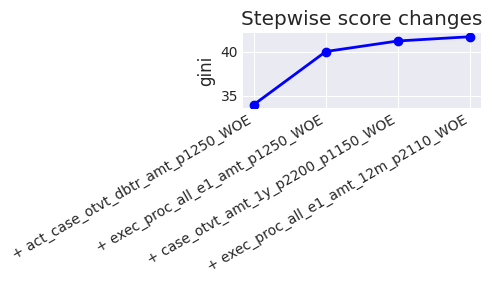

[INFO] [2023-06-01 14:56:29] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-06-01 14:56:29] Dropping features with positive coefs and high p-values...
[INFO] [2023-06-01 14:56:31] Nothing to drop
[INFO] [2023-06-01 14:56:31] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-06-01 14:56:31] intercept = -3.642
[INFO] [2023-06-01 14:56:31] coefs = {'exec_proc_all_e1_amt_p1250_WOE': -0.36, 'exec_proc_all_e1_amt_12m_p2110_WOE': -0.438, 'case_otvt_amt_1y_p2200_p1150_WOE': -0.245, 'act_case_otvt_dbtr_amt_p1250_WOE': -0.63}
[INFO] [2023-06-01 14:56:32] Generating report...


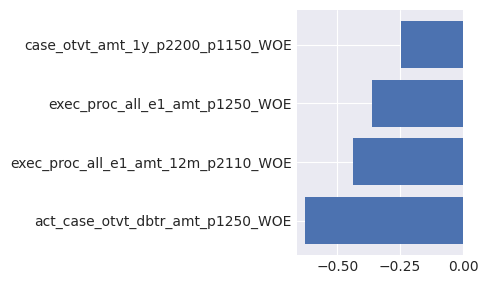

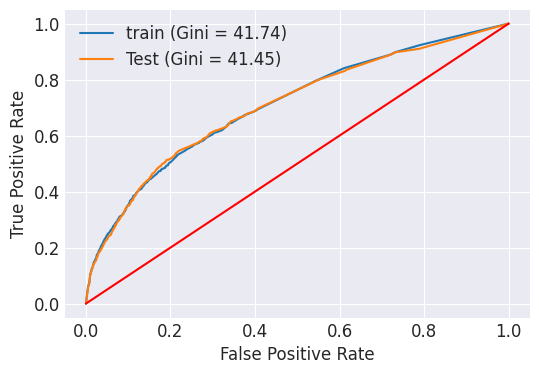

[INFO] [2023-06-01 14:59:13] 
      train   Test  Bootstrap mean  Bootstrap std
Gini  41.74  41.45           41.66            0.8


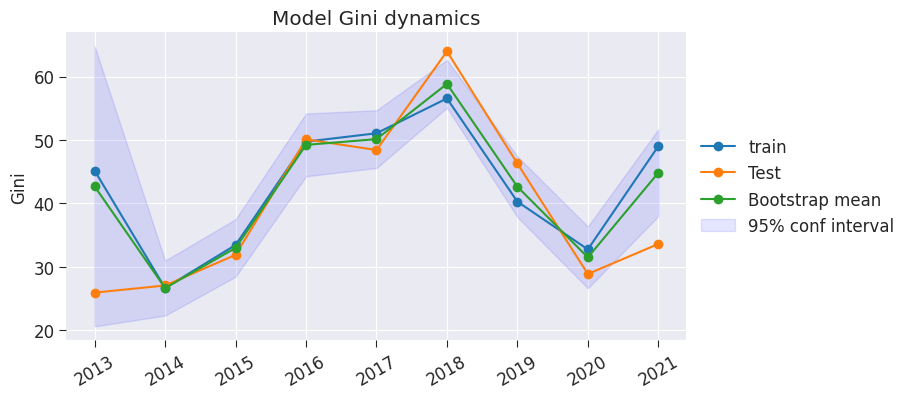

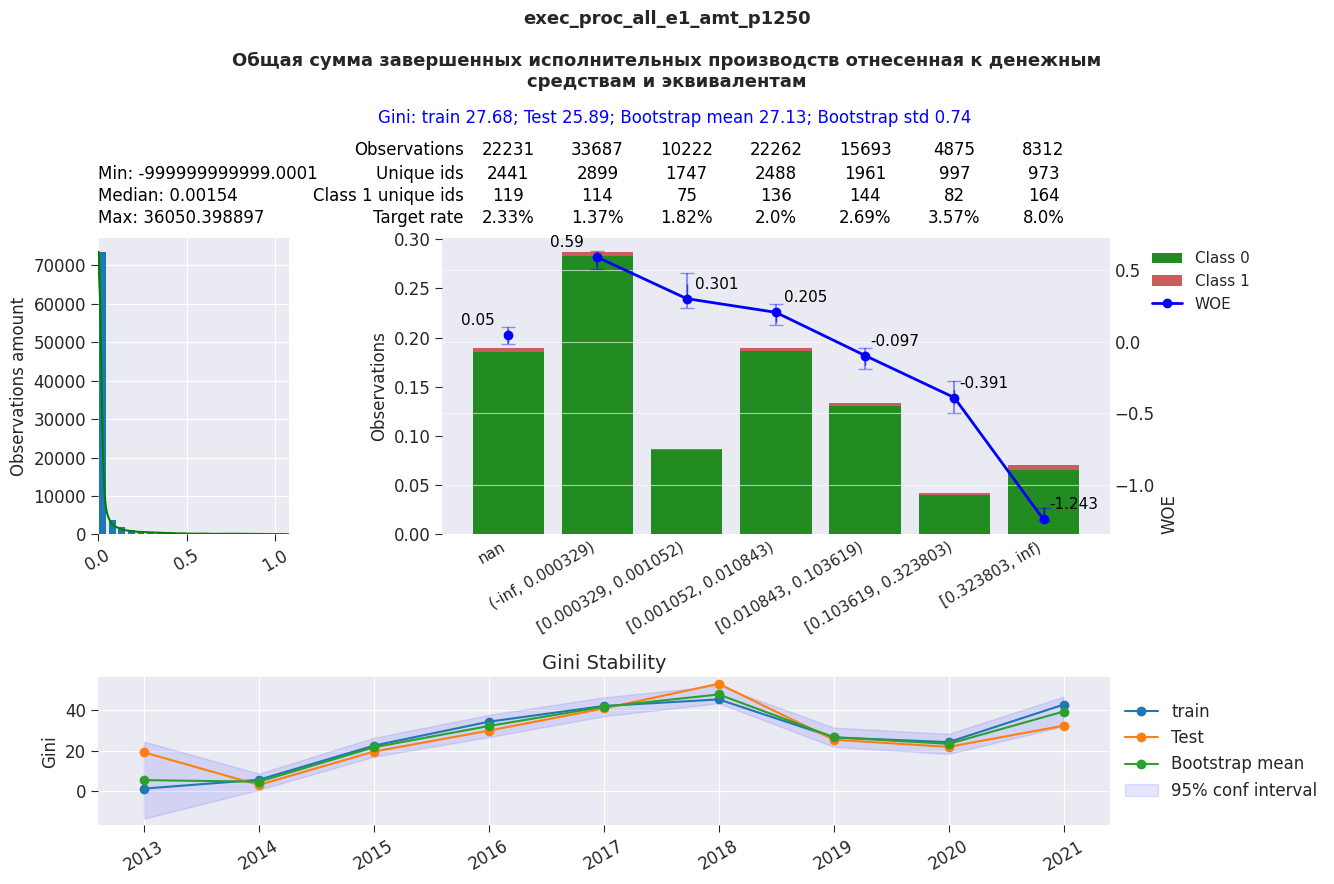

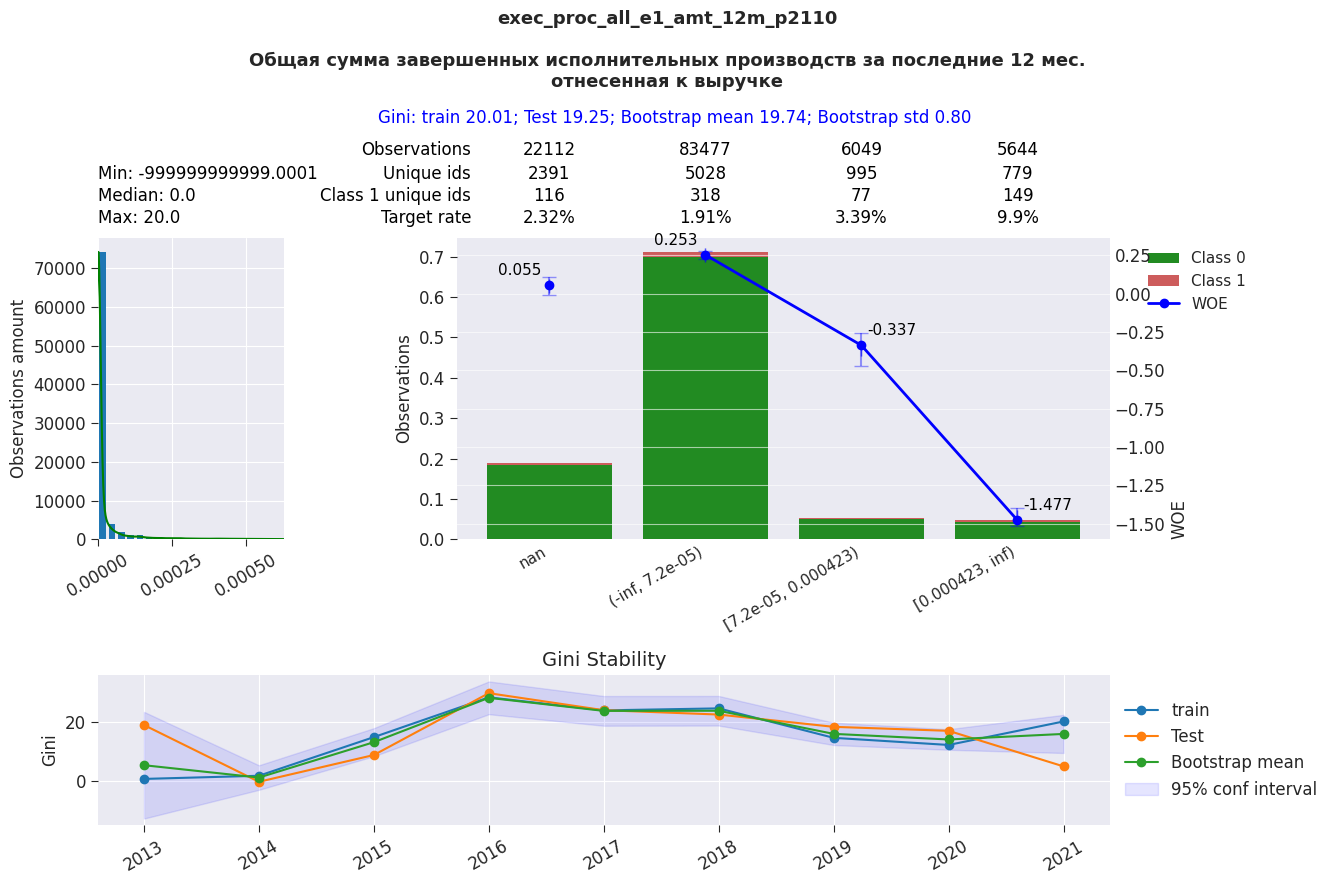

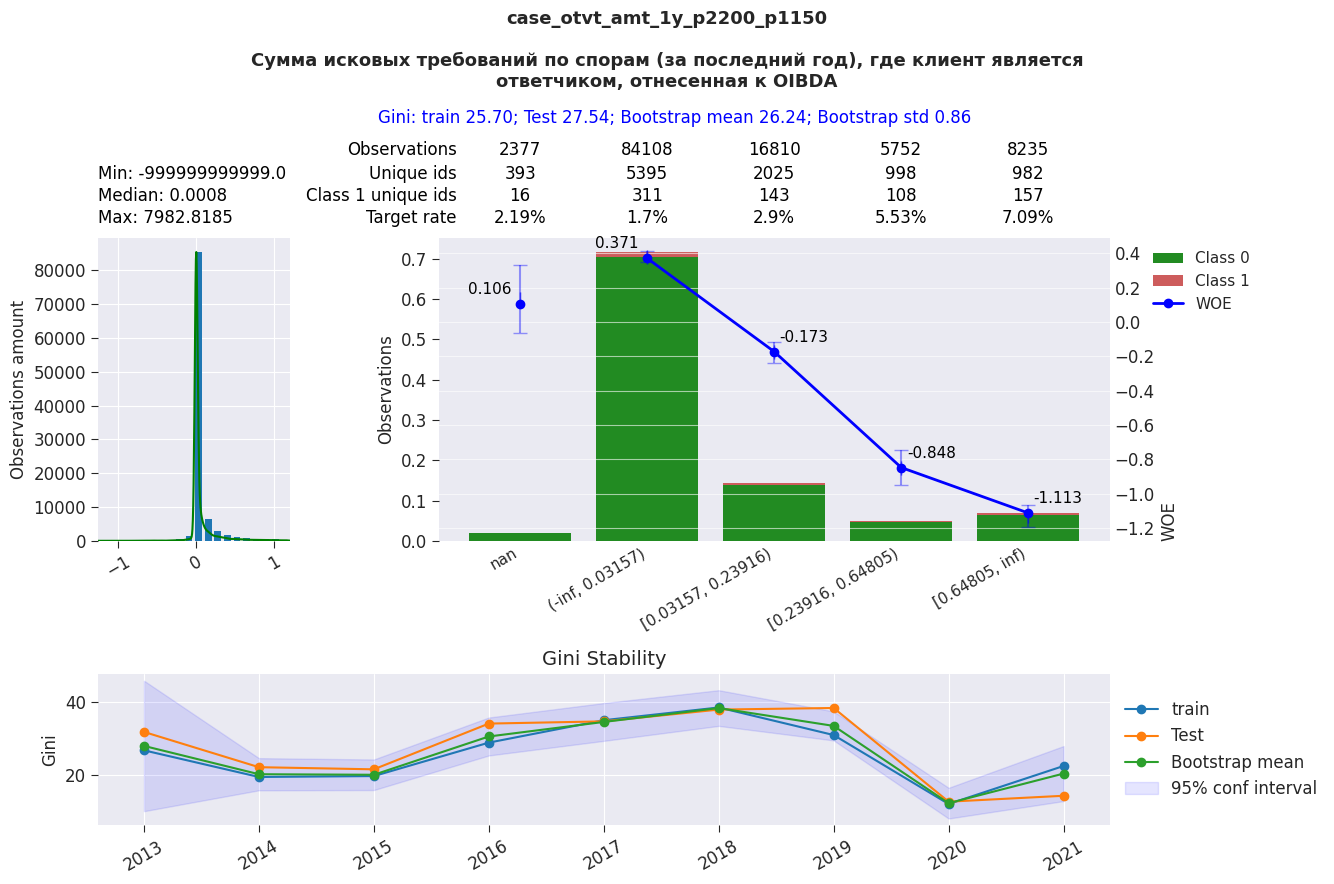

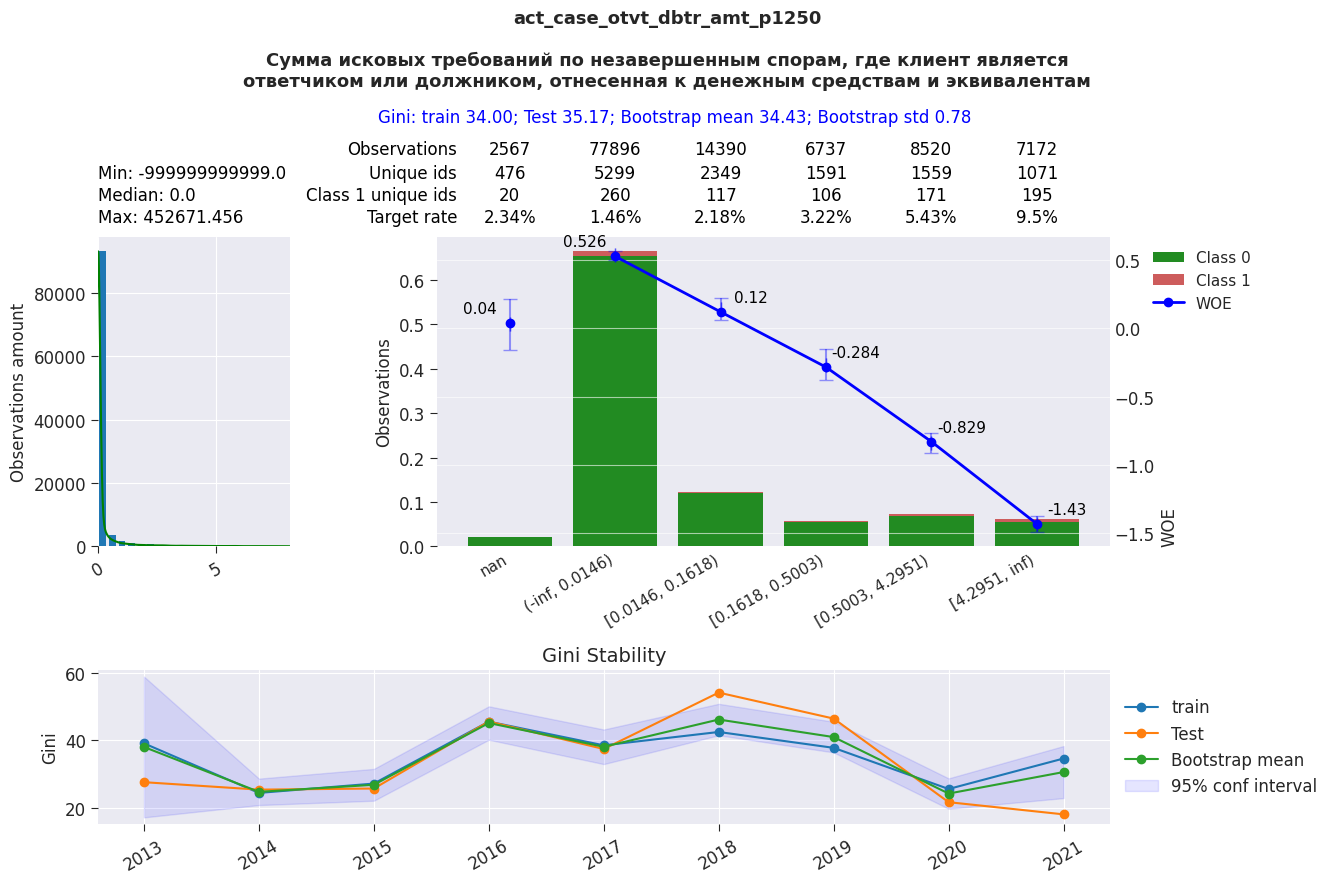


------------------------------------------------------------------------------------- KI --------------------------------------------------------------------------------------

[INFO] [2023-06-01 15:02:17] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-06-01 15:02:17] Performing autobinning with parameters space of size 1...
[INFO] [2023-06-01 15:02:17] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2, 'G_gini_increase_restrict': True, 'G_with_test': False, 'WOEO_on': False, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold'

100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

[INFO] [2023-06-01 15:02:19] Scorecard saved to the file PVR/KI/auto_fit_scorecard.xlsx
[INFO] [2023-06-01 15:02:19] All done! 3/3 features successfully binned.
[INFO] [2023-06-01 15:02:19] Transforming features...


[INFO] [2023-06-01 15:02:20] ------------------------------------------------------------------------ MFA -------------------------------------------------------------------------
[INFO] [2023-06-01 15:04:36] ---------------------------------------------- Step 1 ----------------------------------------------
[INFO] [2023-06-01 15:04:36] Dropped 0 features with gini lower 10: []
[INFO] [2023-06-01 15:04:36] ---------------------------------------------- Step 2 ----------------------------------------------
[INFO] [2023-06-01 15:04:36] Dropped 0 correlated features: []
[INFO] [2023-06-01 15:04:36] ---------------------------------------------- Step 3 ----------------------------------------------
[INFO] [2023-06-01 15:04:36] Stepwise feature selection started...
[INFO] [2023-06-01 15:04:37] To add: industry_high_level_WOE, gini: 20.118, p-value: 1.5388562336311874e-54
[INFO] [2023-06-01 15:04:40] To add: cl_hdlq_amt_p1600_WOE, gini: 30.945, p-value: 2.81718224694006e-175
[INFO] [2023-06-

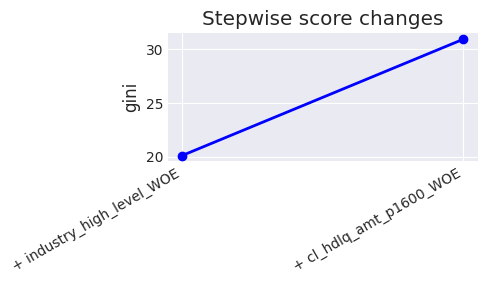

[INFO] [2023-06-01 15:04:42] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-06-01 15:04:42] Dropping features with positive coefs and high p-values...
[INFO] [2023-06-01 15:04:43] Nothing to drop
[INFO] [2023-06-01 15:04:43] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-06-01 15:04:43] intercept = -3.657
[INFO] [2023-06-01 15:04:43] coefs = {'industry_high_level_WOE': -0.756, 'cl_hdlq_amt_p1600_WOE': -0.881}
[INFO] [2023-06-01 15:04:44] Generating report...


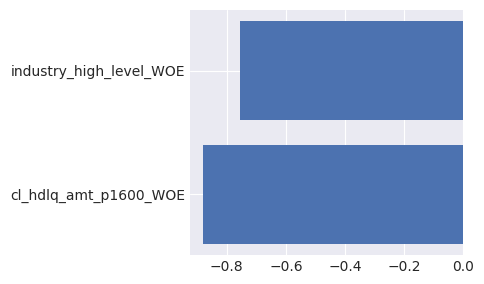

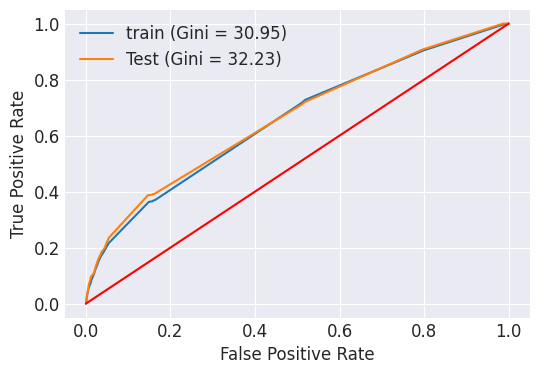

[INFO] [2023-06-01 15:06:58] 
      train   Test  Bootstrap mean  Bootstrap std
Gini  30.95  32.23           31.34           0.83


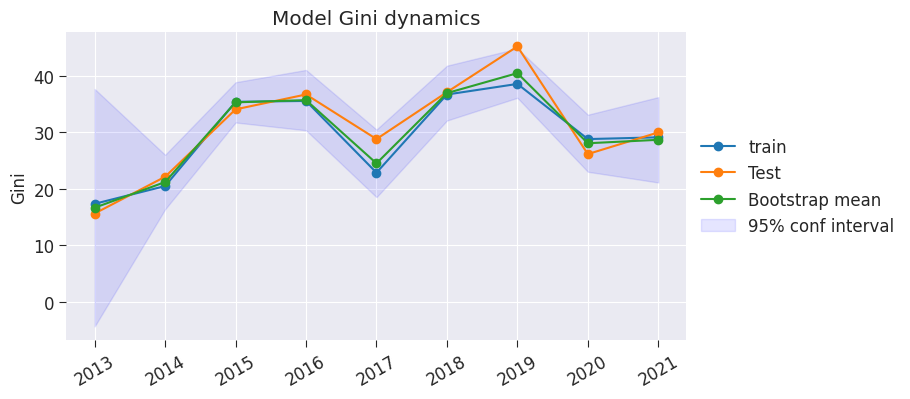

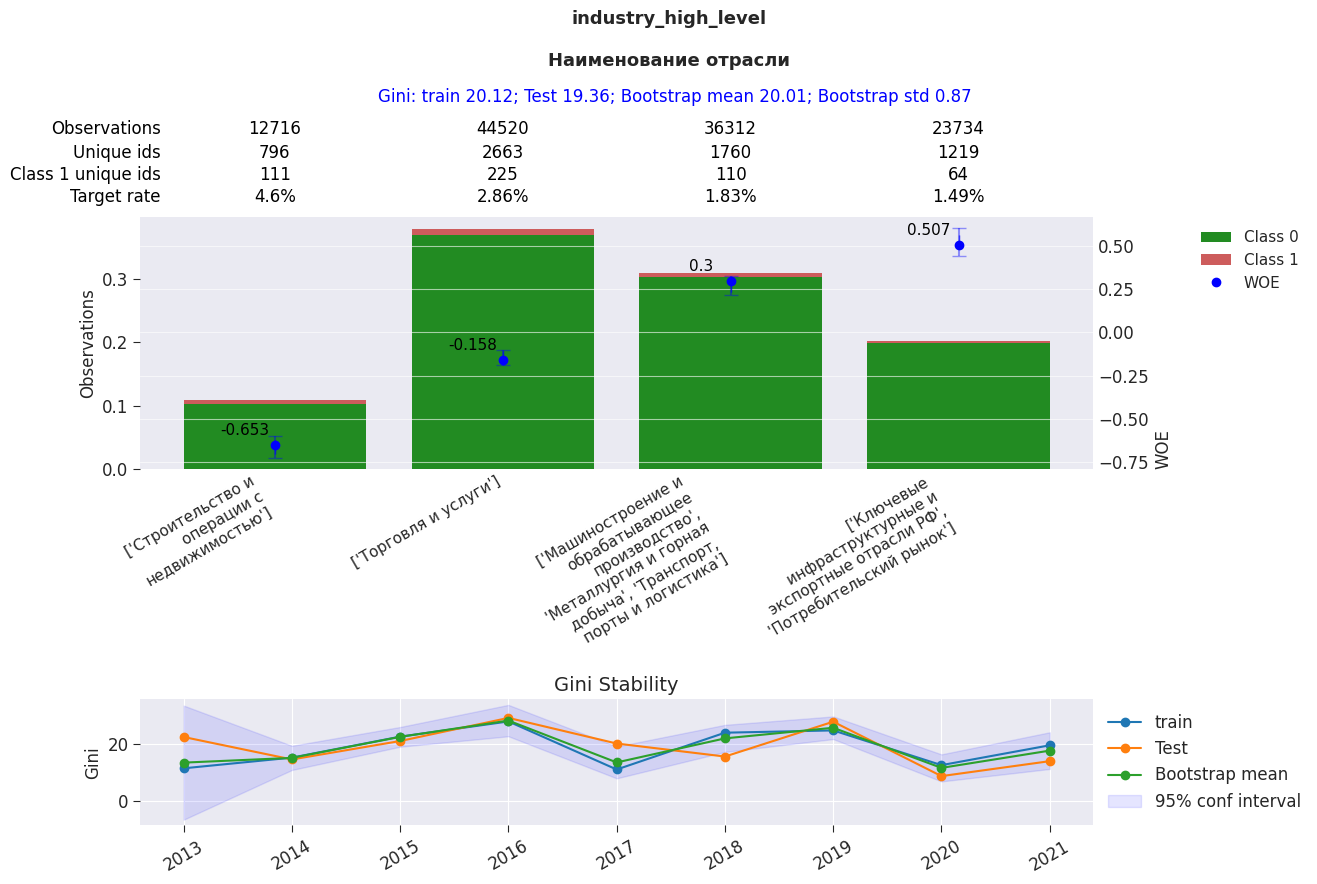

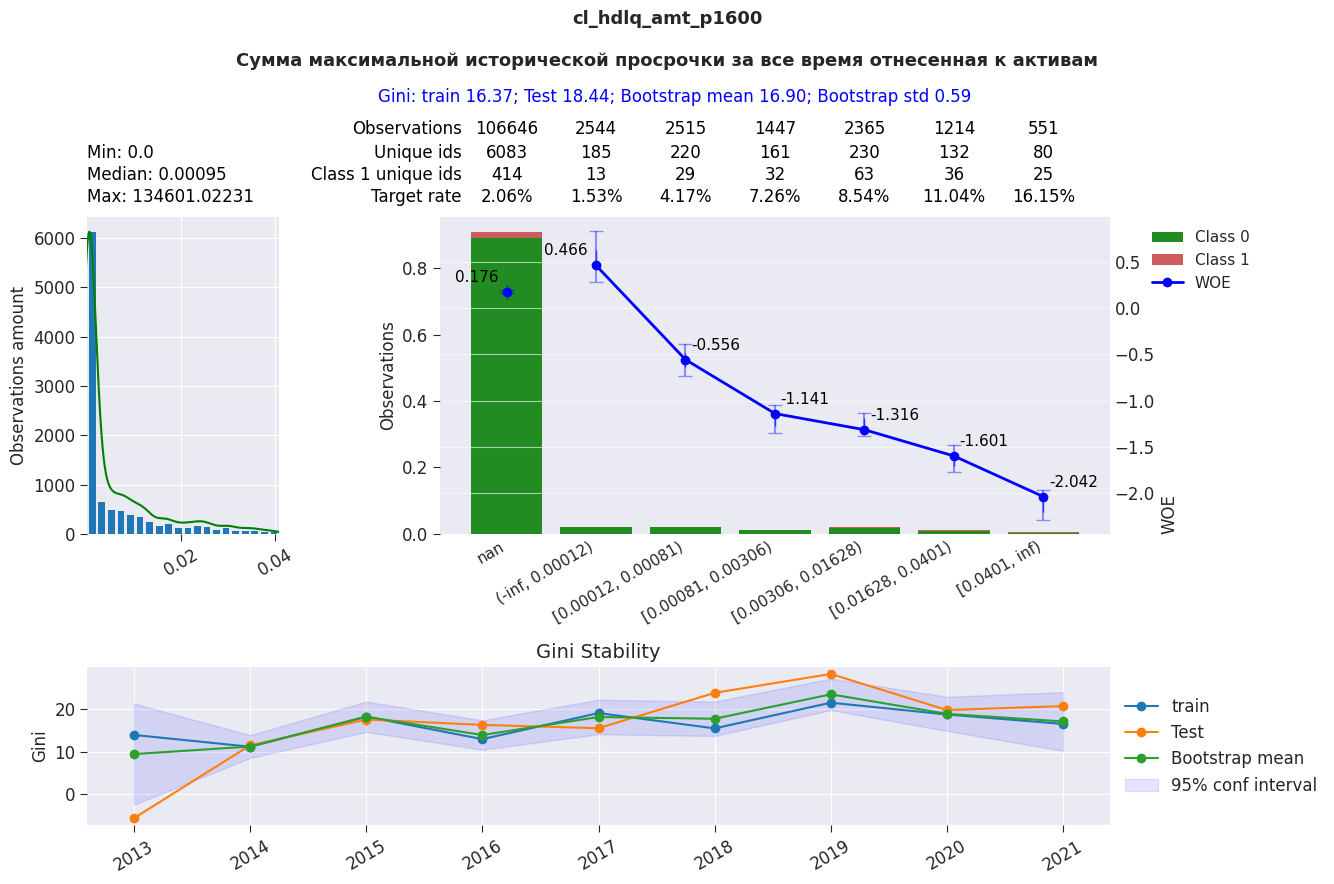

[INFO] [2023-06-01 15:09:13] intercept = 4.668
[INFO] [2023-06-01 15:09:13] coefs = {'FO_score': 0.877, 'PRAVO_score': 0.678, 'KI_score': 0.73, 'random_score': -0.02}
[INFO] [2023-06-01 15:16:03] The cascade was successfully saved to file PVR/FO/auto_cascade.json
CPU times: user 28min 12s, sys: 4min 56s, total: 33min 9s
Wall time: 32min 25s


In [5]:
%%time
cascade.auto_logreg(ds=None,                          # ДатаСэмпл, на котором будет рассчитываться интегральный скор. При None берется self.ds
                    validate=False,                   # флаг для выполнения валидацонных тестов
                    out='auto_cascade.xlsx',          # либо строка с названием эксель файла, либо объект pd.ExcelWriter для сохранения отчета
                    save_model='auto_cascade.json'    # название json файла для сохранения каскада
                   )

## 6. Применение модели
### 6.1. С использованием библиотеки vtb_scorekit

In [6]:
cascade = Cascade()
cascade.load_model(file_name=f'PVR/FO/auto_cascade.json')
cascade.scoring(df,                              # ДатаСэмпл или ДатаФрейм. Возвращается объект того же типа
               score_field='score',              # поле, в которое должен быть записан посчитанный скор
               pd_field='prob',                  # поле, в которое должен быть записан посчитанный PD
               scale_field='scale'               # поле, в которое должен быть записан посчитанный грейд
              ) 

Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
The cascade was loaded from file PVR/FO/auto_cascade.json
Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
[INFO] [2023-06-01 15:16:04] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------


,calc_hub_id,inn,slx,ead,off_bal_ead,on_bal_ead,tot_debt,scale_rwa,train_flg,def_flg,...,FO_score,case_otvt_amt_1y_p2200_p1150_WOE,act_case_otvt_dbtr_amt_p1250_WOE,exec_proc_all_e1_amt_12m_p2110_WOE,exec_proc_all_e1_amt_p1250_WOE,PRAVO_score,industry_high_level_WOE,cl_hdlq_amt_p1600_WOE,KI_score,prob
0,None,4207055973,L6UJ9A001MAH,0.473,None,None,None,None,0,0,...,-5.289,0.371,0.526,0.253,0.205,-4.249,-0.158,0.176,-3.693,0.004
1,None,1435125448,L6UJ9A001R83,0.100,None,None,None,None,1,0,...,-6.014,0.371,0.526,0.253,0.205,-4.249,-0.158,0.176,-3.693,0.002
2,None,3812035570,L6UJ9A000130,4.357,None,None,None,None,1,0,...,-3.682,-1.113,0.120,-0.337,-0.097,-3.262,-0.653,0.176,-3.318,0.039
3,None,3810322900,L6UJ9A009ARZ,0.161,None,None,None,None,0,0,...,-3.411,-0.173,0.526,0.253,0.301,-4.150,-0.158,0.176,-3.693,0.021
4,None,7603031989,L6UJ9A00239V,0.095,None,None,None,None,1,0,...,-3.242,0.371,0.526,0.253,0.205,-4.249,-0.158,0.176,-3.693,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167541,None,3602007714,L6UJ9A0043OU,0.410,None,None,None,None,1,0,...,-3.233,0.371,0.526,0.253,0.205,-4.249,0.507,0.176,-4.195,0.016
167542,None,1414008729,L6UJ9A008Q8U,0.526,None,None,None,None,1,0,...,-4.633,-1.113,-0.829,0.253,0.205,-3.032,0.300,0.176,-4.039,0.012
167543,None,5700000164,L6UJ9A000319,0.050,None,None,None,None,1,0,...,-2.800,0.371,-0.829,0.253,-0.097,-3.287,-0.653,0.176,-3.318,0.080
167544,None,6671228974,L6UJ9A003TPP,0.295,None,None,None,None,0,0,...,-2.732,-0.173,0.526,0.253,0.205,-4.116,-0.158,0.176,-3.693,0.038


### 6.2. Генерация хардкода для использования модели без сторонних библиотек

In [7]:
cascade.to_py(file_name='',                      # название питоновского файла, куда должен быть сохранен код
             score_field='score',                # поле, в которое должен быть записан посчитанный скор
             pd_field='pd',                      # поле, в которое должен быть записан посчитанный PD
             scale_field=None                    # поле, в которое должен быть записан посчитанный грейд
            )

import pandas as pd
import numpy as np


def scoring(df, score_field='score', pd_field='pd', scale_field=None):
    """
    Функция скоринга выборки
    Arguments:
        df: [pd.DataFrame] входной ДатаФрейм, должен содержать все нетрансформированные переменные модели
        score_field: [str] поле, в которое должен быть записан посчитанный скор
        pd_field: [str] поле, в которое должен быть записан посчитанный PD
        scale_field: [str] поле, в которое должен быть записан посчитанный грейд
    Returns:
        df: [pd.DataFrame] выходной ДатаФрейм с добавленными полями трансформированных переменных, скоров, PD и грейда
    """

    df['qn66_cur_acc_turnover_p_WOE'] = np.where((df['qn66_cur_acc_turnover_p'] < 0.000477), 0.425, 
                                                 np.where((df['qn66_cur_acc_turnover_p'] >= 0.000477) & (df['qn66_cur_acc_turnover_p'] < 0.000631), 0.132, 
                                                          np.where((df['qn66_cur_acc_turnover_p'